# Comparing fluxes with other products




In [ ]:
import numpy as np
import xarray as xr

from odc.geo.geobox import zoom_out
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters

In [ ]:
var = 'GPP' #ER #NEE #GPP
var_fc = 'GPP' #TER #NEE #GPP
var_cable = 'gpp' #nbp #er #gpp
suffix='20230109'
trim=True
trim_date = '2003','2021'

results_name = var+'_2003_2021_5km_LGBM_'+suffix+'.nc'
# upper = 'NEE_2003_2021_5km_LGBM_quantiles.nc'

## Open various datasets

In [ ]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)
ds.attrs['nodata'] = np.nan

### Fluxcom

In [ ]:
import xarray as xr

In [ ]:
ds_fc = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var_fc+'_rs.nc'), crs='epsg:4326').sel(time=slice('2003', '2015'))
# ds_fc = ds_fc.rename({'lat':'latitude', 'lon':'longitude'})
ds_fc.attrs['nodata'] = np.nan
ds_fc['latitude'] = ds_fc.latitude.astype('float32')
ds_fc['longitude'] = ds_fc.longitude.astype('float32')

# ds_fc_met = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var_fc+'_rs_meteo_era5.nc').sel(time=slice('2003', '2018')), crs='epsg:4326')
# ds_fc_met = ds_fc_met.rename({'lat':'latitude', 'lon':'longitude'})
# ds_fc_met.attrs['nodata'] = np.nan
# ds_fc_met['latitude'] = ds_fc_met.latitude.astype('float32')
# ds_fc_met['longitude'] = ds_fc_met.longitude.astype('float32')


In [ ]:
ds_fc.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()

In [ ]:
ds_fc['time'] = ds.sel(time=slice('2003', '2015')).time
# ds_fc_met['time'] = ds.sel(time=slice('2003', '2018')).time

### CABLE

<!-- '/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE_ER_10km_monthly_2000_2019.nc' -->

In [ ]:
cable = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-BIOS/CABLE_BIOS_'+var_cable+'_25km_monthly_2003_2019.nc')
# cable_pop = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-POP_v10/CABLE-POP_'+var_cable+'_100km_monthly_2003_2020.nc')
# cable_pop = cable_pop[var_cable]
# cable_nee = cable_nee.sel(time=slice('2003', '2015'))

### Obs GPP

In [ ]:
if var == 'GPP':
    modis_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/MODIS_GPP_1km_monthly_2002_2021.nc')
    modis_gpp.attrs['nodata'] = np.nan
    modis_gpp = modis_gpp * 1000 #convert to g from kg

    gosif_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc')
    gosif_gpp.attrs['nodata'] = np.nan

## Reproject to match the 0.25 CABLE grid

In [ ]:
ds = xr_reproject(ds, geobox=cable.odc.geobox.compat, resampling='bilinear')
# ds_upper = xr_reproject(ds_upper, geobox=ds.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')

In [ ]:
ds_fc = xr_reproject(ds_fc, geobox=cable.odc.geobox.compat, resampling='bilinear')
ds_fc = ds_fc[var_fc] #.where(~mask.astype(bool))
ds_fc = ds_fc*30 #/day to /month

In [ ]:
if var == 'GPP':
    modis_gpp = xr_reproject(modis_gpp, geobox=cable.odc.geobox.compat, resampling='bilinear')
    gosif_gpp = xr_reproject(gosif_gpp, geobox=cable.odc.geobox.compat, resampling='bilinear')

## Export harmonized dataset

In [ ]:
if var == 'GPP':
    merged = xr.merge([
        ds_fc.rename('FLUXCOM_RS_GPP'),
        ds.rename('This_Study_GPP'),
        cable.rename('CABLE_BIOS_GPP'),
        modis_gpp.rename('MODIS_GPP'),
        gosif_gpp.rename('GOSIF_GPP'),
    ])

else:
    merged = xr.merge([
        ds_fc.rename('FLUXCOM_RS_'+var),
        ds.rename('This_Study_'+var),
        cable.rename('CABLE_BIOS_'+var)
    ])

In [ ]:
merged.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/harmonized_'+var+'.nc')

### Extract pixel values from harmonized dataset

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sb
import scipy as sp
from scipy import stats
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from collect_training_data import extract_ec_gridded_data

In [2]:
suffixes = [
    'Emerald/2022_v2/L6/default/Emerald_L6_20110610_20131231_Monthly.nc',
    'GreatWesternWoodlands/2022_v2/L6/default/GreatWesternWoodlands_L6_20130101_20220601_Monthly.nc',
    'CowBay/2022_v2/L6/default/CowBay_L6_20090101_20220816_Monthly.nc',
    'Tumbarumba/2022_v2/L6/default/Tumbarumba_L6_20020107_20220530_Monthly.nc',
    'Whroo/2022_v2/L6/default/Whroo_L6_20111201_20220821_Monthly.nc',
    'WombatStateForest/2022_v2/L6/default/WombatStateForest_L6_20100120_20210529_Monthly.nc',
    'WallabyCreek/2022_v2/L6/default/WallabyCreek_L6_20050825_20130409_Monthly.nc',
    'RobsonCreek/2022_v2/L6/default/RobsonCreek_L6_20130801_20220816_Monthly.nc',
    'CapeTribulation/2022_v2/L6/default/CapeTribulation_L6_20100101_20181102_Monthly.nc',
    'AliceSpringsMulga/2022_v2/L6/default/AliceSpringsMulga_L6_20100903_20220806_Monthly.nc',
    'CalperumChowilla/2022_v2/L6/default/Calperum_L6_20100730_20220829_Monthly.nc',
    'DryRiver/2022_v2/L6/default/DryRiver_L6_20091025_20220820_Monthly.nc',
    'Litchfield/2022_v2/L6/default/Litchfield_L6_20150623_20220513_Monthly.nc',
    'SturtPlains/2022_v2/L6/default/SturtPlains_L6_20080828_20220513_Monthly.nc',
    'RiggsCreek/2022_v2/L6/default/RiggsCreek_L6_20110101_20170712_Monthly.nc', #dryland cropping
    'Otway/2022_v2/L6/default/Otway_L6_20070811_20110101_Monthly.nc', # pasture site
    'Yanco/2022_v2/L6/default/Yanco_L6_20130101_20220821_Monthly.nc', # soil site
    
    ## check the location of these ones below as they are new additions
    'Gingin/2022_v2/L6/default/Gingin_L6_20111013_20210614_Monthly.nc', # native Banksia woodland
    'LongreachMitchellGrassRangeland/2022_v2/L6/default/Longreach_L6_20181009_20220607_Monthly.nc',
    'Ridgefield/2022_v2/L6/default/Ridgefield_L6_20160101_20220821_Monthly.nc', #  dryland agriculture
    'SilverPlains/2022_v2/L6/default/SilverPlains_L6_20200101_20211231_Monthly.nc', #Australian Mountain Reseach 
    'Collie/2022_v2/L6/default/Collie_L6_20170804_20191111_Monthly.nc', # wandoo woodland
    'AdelaideRiver/2022_v2/L6/default/AdelaideRiver_L6_20071017_20090524_Monthly.nc', #  Savanna dominated by Eucalyptus
    'Warra/2022_v2/L6/default/Warra_L6_20130305_20210921_Monthly.nc', #tasmania
    
    ### ----------Problematic sites--------
    #'DalyPasture/2022_v2/L6/default/DalyPasture_L6_20080101_20130908_Monthly.nc', #fragmented landscape, pasture among native veg fragments
    #'DalyUncleared/2022_v1/L6/default/DalyUncleared_L6_20080101_20220217_Monthly.nc', #Woodland savanna LOTS OF UNCERTAINTY IN THIS SITE - Peter Isaac
    'CumberlandPlain/2022_v2/L6/default/CumberlandPlain_L6_20140101_20220820_Monthly.nc',# small remnant bushland block in ag district
    'SamfordEcologicalResearchFacility/2022_v2/L6/default/Samford_L6_20100602_20171231_Monthly.nc', #fragmented landscape 5km resolution not good enough
    'Boyagin/2022_v2/L6/default/Boyagin_L6_20171020_20220821_Monthly.nc', # in remnant forest around crops, BORDERLINE MIGHT BE OKAY
    'TiTreeEast/2022_v1/L6/default/TiTreeEast_L6_20120718_20220117_Monthly.nc', 
    #'RedDirtMelonFarm/2021_v1/L6/default/RedDirtMelonFarm_L6_20110923_20130721_Monthly.nc', #small farm in the middle of savannah woodland
    'FoggDam/2022_v2/L6/default/FoggDam_L6_20060207_20081031_Monthly.nc', # wetland that floods seasonally
    #'Loxton/2022_v1/L6/default/Loxton_L6_20080819_20090609_Monthly.nc' # almond tress, 1 year of data
]

i=0
sites = []
for suffix in suffixes:
    print(" {:02}/{:02}\r".format(i + 1, len(suffixes)), end="")
    xx = extract_ec_gridded_data(suffix,
                                 covariables=['kNDVI'],
                                 scale='1km',
                                 save_ec_data=False,
                                 verbose=False,
                                 add_comparisons=True,
                                 export_path='/g/data/os22/chad_tmp/NEE_modelling/results/harmonized/'
                                )
    sites.append(xx)
    i+=1

In [3]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/harmonized/'
sites = os.listdir(base)

td = []
for site in sites:
    if '.csv' in site:
        xx = pd.read_csv(base+site, index_col='time', parse_dates=True)
        xx['site'] = site[0:5]
        td.append(xx)

df = pd.concat(td)

In [4]:
df = df[['NEE_SOLO_EC', 'GPP_SOLO_EC', 'ER_SOLO_EC', 'FLUXCOM_RS_NEE',
       'CABLE_BIOS_NEE', 'FLUXCOM_RS_GPP', 'GOSIF_GPP', 'DIFFUSE_GPP', 'FLUXCOM_RS_ER',
       'CABLE_BIOS_GPP', 'MODIS_GPP', 'CABLE_BIOS_ER', 'site', 'This_Study_NEE', 'This_Study_GPP', 'This_Study_ER'
        ]]
 # 
df = df.dropna()
df

,NEE_SOLO_EC,GPP_SOLO_EC,ER_SOLO_EC,FLUXCOM_RS_NEE,CABLE_BIOS_NEE,FLUXCOM_RS_GPP,GOSIF_GPP,DIFFUSE_GPP,FLUXCOM_RS_ER,CABLE_BIOS_GPP,MODIS_GPP,CABLE_BIOS_ER,site,This_Study_NEE,This_Study_GPP,This_Study_ER
time,,,,,,,,,,,,,,,,
2003-01-15,-56.087957,246.117272,107.669355,-48.273956,113.449422,215.296390,160.6175,229.663700,153.567200,267.163131,244.570650,383.264141,Tumba,-58.002304,234.918000,101.822365
2003-02-15,-35.563580,219.719966,84.254458,-42.197950,105.851457,211.351680,142.2825,219.012330,155.858840,214.849844,273.391800,328.292988,Tumba,-34.509556,207.761230,81.586810
2003-03-15,-7.807840,174.197431,53.608883,-40.290302,52.585227,199.482670,135.8650,152.743770,141.682250,187.572055,275.978120,238.483075,Tumba,-36.077120,183.784100,66.837746
2003-04-15,27.053094,89.371514,34.264556,-27.232533,26.965620,162.651920,104.8650,95.930110,115.542660,167.731743,152.010820,195.945345,Tumba,-24.158888,123.768234,43.258297
2003-05-15,2.122000,103.840758,28.083156,-10.326498,29.231188,121.130230,80.4025,49.332520,95.371950,135.082858,140.007390,165.204737,Tumba,-22.737534,95.096510,34.286892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-15,-51.921720,119.859371,50.264019,-15.792353,-32.463925,74.197044,89.4125,107.690384,59.414330,163.058112,114.497665,130.515558,Cumbe,-31.080166,98.284300,43.410217
2015-09-15,-40.489497,125.321320,61.696768,-27.381155,-47.091965,105.115944,127.8500,143.997040,76.838615,193.897900,116.801636,146.750363,Cumbe,-35.988960,116.559590,55.632595
2015-10-15,-8.429303,141.450000,58.620839,-20.835783,-17.142863,106.854240,146.6025,164.798920,86.048874,204.232547,116.643680,187.115453,Cumbe,-19.377403,124.163880,58.732820


## Plot

In [ ]:
# fig,ax = plt.subplots(3,1, figsize=(11,11), sharex=True)
# df[df['site']=='Tumba']['ER_SOLO_EC'].plot(ax=ax[0], label='Obs. ER')
# df[df['site']=='Tumba']['This_Study_ER'].plot(ax=ax[0], label='This Study ER')
# df[df['site']=='Tumba']['FLUXCOM_RS_ER'].plot(ax=ax[0], label='FLUXCOM-RS ER')
# ax[0].legend()
# ax[0].set_ylabel('ER (gC m\N{SUPERSCRIPT TWO} m⁻¹)')
# df[df['site']=='Tumba']['GPP_SOLO_EC'].plot(ax=ax[1], label='Obs. GPP')
# df[df['site']=='Tumba']['This_Study_GPP'].plot(ax=ax[1], label='This Study GPP')
# df[df['site']=='Tumba']['FLUXCOM_RS_GPP'].plot(ax=ax[1], label='FLUXCOM-RS GPP')
# ax[1].legend()
# ax[1].set_ylabel('GPP (gC m\N{SUPERSCRIPT TWO} m⁻¹)')
# df[df['site']=='Tumba']['NEE_SOLO_EC'].plot(ax=ax[2], label='Obs. NEE')
# df[df['site']=='Tumba']['This_Study_NEE'].plot(ax=ax[2], label='This Study NEE')
# df[df['site']=='Tumba']['FLUXCOM_RS_NEE'].plot(ax=ax[2], label='FLUXCOM-RS NEE')
# ax[2].axhline(0, c='grey')
# ax[2].set_ylabel('NEE (gC m\N{SUPERSCRIPT TWO} m⁻¹)')
# ax[2].legend()
# plt.tight_layout();

In [5]:
var='GPP'

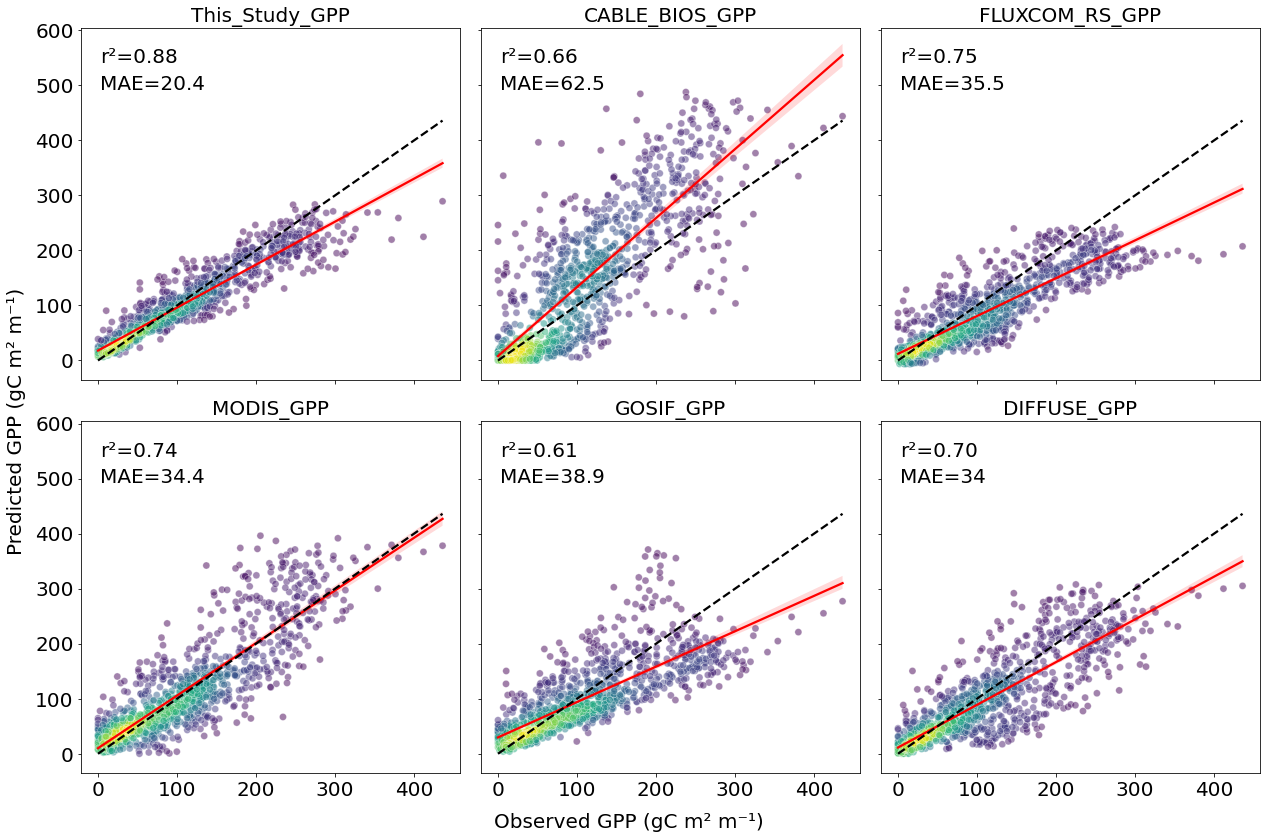

In [7]:
if var == 'GPP':
    products=['This_Study_'+var,'CABLE_BIOS_'+var, 'FLUXCOM_RS_'+var, 'MODIS_'+var, 'GOSIF_'+var, 'DIFFUSE_'+var] #
    fig,axes = plt.subplots(2,3, figsize=(18,12), sharey=True, sharex=True)
    
else:
    products=['This_Study_'+var, 'CABLE_BIOS_'+var, 'FLUXCOM_RS_'+var] #'This_Study_'+var,
    fig,axes = plt.subplots(1,3, figsize=(18,7), sharey=True, sharex=True)

for prod, ax in zip(products, axes.ravel()):
    
    obs,pred = df[var+'_SOLO_EC'].values, df[prod].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2 = r_value**2
    # r2 = r2_score(obs, pred)
    # r2 = sp.stats.pearsonr(obs, pred)
    ac = mean_absolute_error(obs, pred)
    
    xy = np.vstack([obs,pred])
    z = gaussian_kde(xy)(xy)

    sb.scatterplot(data=df, x=var+'_SOLO_EC',y=prod, c=z, s=50, lw=1, alpha=0.5, ax=ax)
    sb.regplot(data=df, x=var+'_SOLO_EC',y=prod, scatter=False, color='blue', ax=ax)
    sb.regplot(data=df, x=var+'_SOLO_EC',y=var+'_SOLO_EC', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
    ax.set_title(prod, fontsize=20)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_aspect(1.5)
    ax.text(.05, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=20)
    ax.text(.05, .825, 'MAE={:.3g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

fig.supylabel('Predicted '+var+' (gC m\N{SUPERSCRIPT TWO} m⁻¹)', fontsize=20)
fig.supxlabel('Observed '+var+' (gC m\N{SUPERSCRIPT TWO} m⁻¹)', fontsize=20, y=0.025);
plt.tight_layout(pad=1.75)
fig.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/cross_val_intercomparison_'+var+'.png', bbox_inches='tight')